In [ ]:
import pickle as pkl
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

def get_numeric_template(cam_mat, before, fs=90):

    peak_loc = int(before*fs)
    pwave_start = peak_loc - int(0.25*fs)
    pwave_end = peak_loc - int(0.1*fs)
    s_peak = peak_loc + int(0.13*fs)
    t_peak_end = peak_loc + int(0.4*fs)

    pwave_activation = cam_mat[pwave_start:pwave_end, :].copy()
    qrs_activation = cam_mat[pwave_end:s_peak, :].copy()

    qr_activation = cam_mat[pwave_end:peak_loc, :].copy()
    rs_activation = cam_mat[peak_loc:s_peak, :].copy()
    st_activation = cam_mat[s_peak:t_peak_end, :].copy()

    mean_pwave = np.mean(np.mean(pwave_activation, axis=1))
    pwave_std = np.std(pwave_activation) / np.sqrt(np.size(pwave_activation))
    print(f'mean_pwave: {mean_pwave:.2f}, pwave std: {pwave_std:.5f}')

    qr_mean = np.mean(np.mean(qr_activation, axis=1))
    qr_std = np.std(qr_activation) / np.sqrt(np.size(qr_activation))
    print(f'qr_mean: {qr_mean:.2f}, qr std: {qr_std:.5f}')

    rs_mean = np.mean(np.mean(rs_activation, axis=1))
    rs_std = np.std(rs_activation) / np.sqrt(np.size(rs_activation))
    print(f'rs_mean: {rs_mean:.2f}, qr std: {rs_std:.5f}')

    st_mean = np.mean(np.mean(st_activation, axis=1))
    st_std = np.std(st_activation) / np.sqrt(np.size(st_activation))
    print(f'st_mean: {st_mean:.2f}, qr std: {st_std:.5f}')

    qrs_mean = np.mean(np.mean(qrs_activation, axis=1))
    qrs_std = np.std(qrs_activation) / np.sqrt(np.size(qrs_activation))
    print(f'qrs_mean: {qrs_mean:.2f}, qr std: {qrs_std:.5f}')

    return


In [ ]:

def plot_cam_template(file_name, plot_noisy, noise_levels_to_remove=None):
    if noise_levels_to_remove is None:
        noise_levels_to_remove = []

    base_data_path = os.path.join('ECG', 'saved_models', file_name)
    
    try:
        with open(os.path.join(base_data_path, f'figure_data_noise=0.0.pkl'), 'rb') as h:
            save_data = pkl.load(h)
    except FileNotFoundError:
        print(f"Error: File not found at {os.path.join(base_data_path, f'figure_data_noise=0.0.pkl')}")
        print(f"Current working directory: {os.getcwd()}")
        return None

    total_mean_activation = save_data['total_mean_activation']
    total_activation_std = save_data['total_activation_std']
    templates = save_data['cam_mat']
    templates_sig = save_data.get('sig_mat', None)
    before = save_data['before']
    after = save_data['after']
    
    if not isinstance(templates, np.ndarray) or templates.ndim == 0 or templates.shape[0] == 0:
        print("Error: 'cam_mat' (templates) is empty or invalid.")
        return None
    
    num_rpeaks = templates.shape[1] if templates.ndim > 1 else 1

    if not plot_noisy:
        print(f'total activation mean: {total_mean_activation:.2f}, total activation std: {total_activation_std:.5f}')
        print(f'Averaged over {num_rpeaks} detections')

    templates_ts = np.linspace(-before * 1000, after * 1000, templates.shape[0], endpoint=False)
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    mean_cam = np.mean(templates, axis=1)

    ax.plot(templates_ts, mean_cam, color='black', label='CAM')

    if not plot_noisy and templates_sig is not None:
        if isinstance(templates_sig, np.ndarray) and templates_sig.ndim > 0 and templates_sig.shape[0] > 0:
            mean_sig = 0.5 * np.mean(templates_sig, axis=1) + 0.2
            ax.plot(templates_ts, mean_sig, color='gray', linewidth=2, alpha=0.7, label='ECG')

    if plot_noisy:
        noise_files_path = base_data_path
        list_of_noise_files = glob.glob(os.path.join(noise_files_path, f'figure_data_noise=*'))

        if not list_of_noise_files:
            print(f"No noise files found in {noise_files_path} with pattern 'figure_data_noise=*'")
        
        list_of_noise_levels_all = []
        for file in list_of_noise_files:
            try:
                level_str = file.split('noise=')[1].split('.pkl')[0]
                list_of_noise_levels_all.append(float(level_str))
            except (IndexError, ValueError) as e:
                print(f"Warning: Could not parse noise level from file name: {file}. Error: {e}")
                continue

        list_of_noise_levels_valid = list(filter(lambda x: x > 0, list_of_noise_levels_all))
        list_of_noise_levels_valid = list(filter(lambda x: x not in noise_levels_to_remove, list_of_noise_levels_valid))
        
        noise_file_map = {}
        for f in list_of_noise_files:
            if 'noise=' in f and '.pkl' in f:
                 try:
                    level = float(f.split('noise=')[1].split('.pkl')[0])
                    noise_file_map[level] = f
                 except (IndexError, ValueError):
                     continue


        list_of_noise_levels_valid = sorted(list_of_noise_levels_valid)
        list_of_noise_files_valid = [noise_file_map[level] for level in list_of_noise_levels_valid if level in noise_file_map]
        
        num_valid_levels = len(list_of_noise_levels_valid)
        if num_valid_levels > 0:
            colors = plt.cm.get_cmap('viridis', num_valid_levels)
        else:
            colors = None

        for i_noise, noise_level in enumerate(list_of_noise_levels_valid):
            file_path = list_of_noise_files_valid[i_noise]
            try:
                with open(file_path, 'rb') as h:
                    save_data_noise = pkl.load(h)
                
                if 'cam_mat' not in save_data_noise or not isinstance(save_data_noise['cam_mat'], np.ndarray) or \
                   save_data_noise['cam_mat'].ndim == 0 or save_data_noise['cam_mat'].shape[0] == 0:
                    print(f"Warning: 'cam_mat' is empty or invalid in noise file: {file_path}")
                    continue

                mean_cam_noise = np.mean(save_data_noise['cam_mat'], axis=1)
                if colors:
                    ax.plot(templates_ts, mean_cam_noise, label=f'Noise: {noise_level:.2f}', color=colors(i_noise))
                else: # Fallback if colors somehow not initialized (e.g. num_valid_levels was 0)
                    ax.plot(templates_ts, mean_cam_noise, label=f'Noise: {noise_level:.2f}')
            except FileNotFoundError:
                print(f"Warning: Noise file not found: {file_path}")
            except Exception as e:
                print(f"Warning: Could not load or plot data for noise level {noise_level} from {file_path}. Error: {e}")

    ax.set_xlabel('Time [ms]', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    plt.legend(fontsize=10)
    plt.title(f'CAM Template: {file_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

    return fig



## Baseline

Accuracy: 89.82
F1 AF: 0.895
F1 NAF: 0.901
R2 rr: 0.513
R2 pwave: 0.094

Rep2Label Accuracy: 94.84
Rep2Label F1 AF: 0.72
Rep2Label F1 NAF: 0.97

total activation mean: 0.23, total activation std: 0.00111
Averaged over 3839 detections


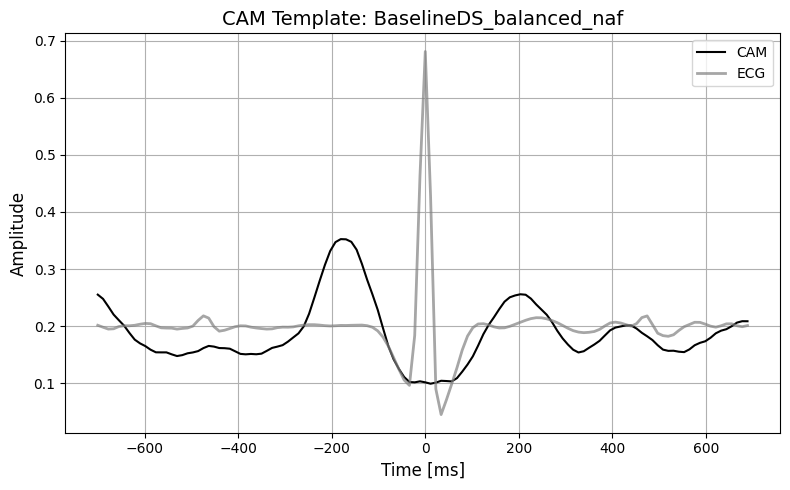

In [34]:
file_name = 'BaselineDS_balanced_naf'
with open(f'ECG/saved_models/{file_name}/{file_name}_test_res.pkl', 'rb') as f:
    baseline_test_res = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_test_r2_rr_included_fixed.pkl', 'rb') as f:
    baseline_r2_rr = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_test_r2_p_wave_excluded_fixed.pkl', 'rb') as f:
    baseline_r2_pwave = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_rep2label_perf.pkl', 'rb') as f:
    rep2label_perf = pkl.load(f)
    
rep2label_acc = np.mean([rep2label_perf[i]['accuracy'] for i in range(5)])
rep2label_F1_NAF = np.mean([rep2label_perf[i]['f1_normal'] for i in range(5)])
rep2label_F1_AF = np.mean([rep2label_perf[i]['f1_af'] for i in range(5)])
baseline_acc    = baseline_test_res['accuracy']
baseline_F1_NAF = baseline_test_res['f1_normal']
baseline_F1_AF  = baseline_test_res['f1_af']

print(f'Accuracy: {baseline_acc:.2f}')
print(f'F1 AF: {baseline_F1_AF:.3f}')
print(f'F1 NAF: {baseline_F1_NAF:.3f}')
print(f'R2 rr: {baseline_r2_rr:.3f}')
print(f'R2 pwave: {baseline_r2_pwave:.3f}')
print("")
print(f'Rep2Label Accuracy: {rep2label_acc:.2f}')
print(f'Rep2Label F1 AF: {rep2label_F1_AF:.2f}')
print(f'Rep2Label F1 NAF: {rep2label_F1_NAF:.2f}')
print("")

plot_noisy = False
fig=plot_cam_template(file_name=file_name,plot_noisy=plot_noisy);
suffix = '_noise' if plot_noisy else ''
fig.savefig(f'Figures/Baseline{suffix}.png', dpi=500)

## RR model

Accuracy: 92.73
F1 AF: 0.702
F1 NAF: 0.959
R2 rr: -0.009
R2 pwave: -0.053

Rep2Label Accuracy: 54.84
Rep2Label F1 AF: 0.36
Rep2Label F1 NAF: 0.49

total activation mean: 0.00, total activation std: 0.00004
Averaged over 3839 detections


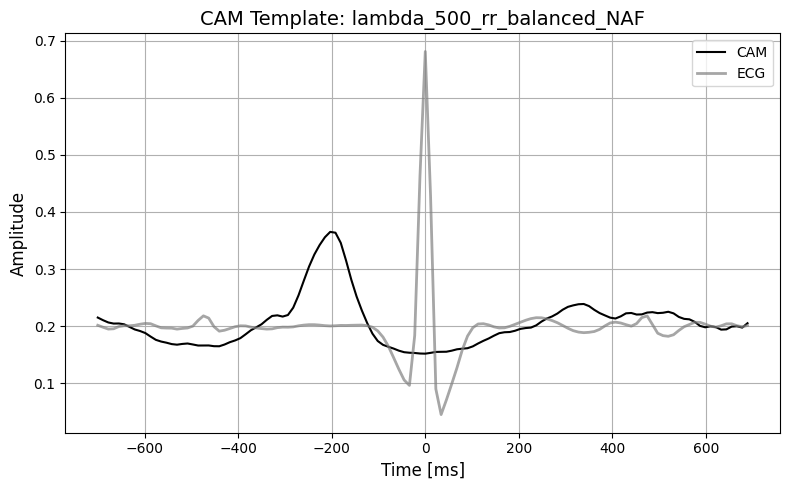

In [35]:
file_name = 'lambda_500_rr_balanced_NAF'
with open(f'ECG/saved_models/{file_name}/{file_name}_test_res.pkl', 'rb') as f:
    rr_test_res = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_test_r2_rr_included_fixed.pkl', 'rb') as f:
    rr_r2_rr = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_test_r2_p_wave_excluded_fixed.pkl', 'rb') as f:
    rr_r2_pwave = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_rep2label_perf.pkl', 'rb') as f:
    rep2label_perf = pkl.load(f)
    
rep2label_acc = np.mean([rep2label_perf[i]['accuracy'] for i in range(5)])
rep2label_F1_NAF = np.mean([rep2label_perf[i]['f1_normal'] for i in range(5)])
rep2label_F1_AF = np.mean([rep2label_perf[i]['f1_af'] for i in range(5)])
    
rr_acc    = rr_test_res['accuracy']
rr_F1_NAF = rr_test_res['f1_normal']
rr_F1_AF  = rr_test_res['f1_af']
print(f'Accuracy: {rr_acc:.2f}')
print(f'F1 AF: {rr_F1_AF:.3f}')
print(f'F1 NAF: {rr_F1_NAF:.3f}')
print(f'R2 rr: {rr_r2_rr:.3f}')
print(f'R2 pwave: {rr_r2_pwave:.3f}')
print("")
print(f'Rep2Label Accuracy: {rep2label_acc:.2f}')
print(f'Rep2Label F1 AF: {rep2label_F1_AF:.2f}')
print(f'Rep2Label F1 NAF: {rep2label_F1_NAF:.2f}')
print("")

plot_noisy = False
fig = plot_cam_template(file_name=file_name,plot_noisy=plot_noisy)
suffix = '_noise' if plot_noisy else ''
fig.savefig(f'Figures/RR{suffix}.png', dpi=500)

## P-Wave

Accuracy: 89.74
F1 AF: 0.890
F1 NAF: 0.904
R2 rr: -0.032
R2 pwave: -0.082

Rep2Label Accuracy: 57.90
Rep2Label F1 AF: 0.45
Rep2Label F1 NAF: 0.59

total activation mean: 0.01, total activation std: 0.00006
Averaged over 3839 detections


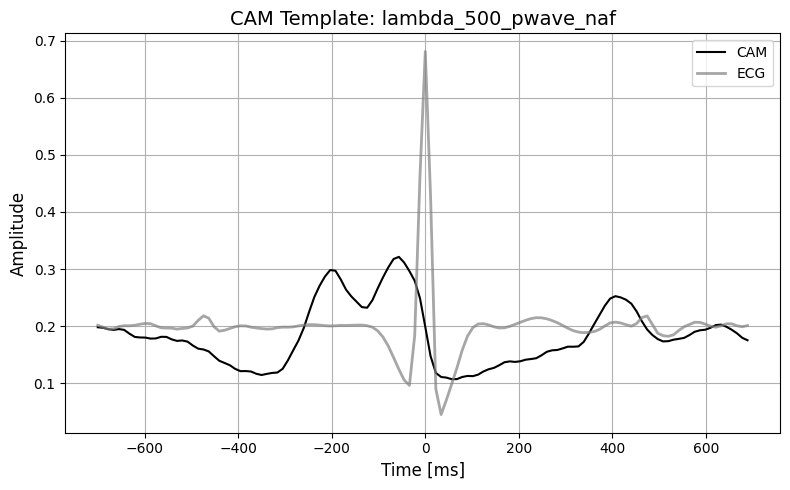

In [36]:
file_name = 'lambda_500_pwave_naf'
with open(f'ECG/saved_models/{file_name}/{file_name}_test_res.pkl', 'rb') as f:
    pwave_test_res = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_test_r2_rr_excluded_fixed.pkl', 'rb') as f:
    pwave_r2_rr = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_test_r2_p_wave_included_fixed.pkl', 'rb') as f:
    pwave_r2_pwave = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_rep2label_perf.pkl', 'rb') as f:
    rep2label_perf = pkl.load(f)
    
rep2label_acc = np.mean([rep2label_perf[i]['accuracy'] for i in range(5)])
rep2label_F1_NAF = np.mean([rep2label_perf[i]['f1_normal'] for i in range(5)])
rep2label_F1_AF = np.mean([rep2label_perf[i]['f1_af'] for i in range(5)])
    
pwave_acc    = pwave_test_res['accuracy']
pwave_F1_NAF = pwave_test_res['f1_normal']
pwave_F1_AF  = pwave_test_res['f1_af']

print(f'Accuracy: {pwave_acc:.2f}')
print(f'F1 AF: {pwave_F1_AF:.3f}')
print(f'F1 NAF: {pwave_F1_NAF:.3f}')
print(f'R2 rr: {pwave_r2_rr:.3f}')
print(f'R2 pwave: {pwave_r2_pwave:.3f}')
print("")
print(f'Rep2Label Accuracy: {rep2label_acc:.2f}')
print(f'Rep2Label F1 AF: {rep2label_F1_AF:.2f}')
print(f'Rep2Label F1 NAF: {rep2label_F1_NAF:.2f}')
print("")

plot_noisy = False
fig = plot_cam_template(file_name=file_name,plot_noisy=plot_noisy)
suffix = '_noise' if plot_noisy else ''
fig.savefig(f'Figures/PWave{suffix}.png', dpi=500)

## ALL

Accuracy: 92.08
F1 AF: 0.915
F1 NAF: 0.926
R2 rr: -0.032
R2 pwave: -0.055

Rep2Label Accuracy: 51.77
Rep2Label F1 AF: 0.15
Rep2Label F1 NAF: 0.54

total activation mean: 0.00, total activation std: 0.00005
Averaged over 3839 detections


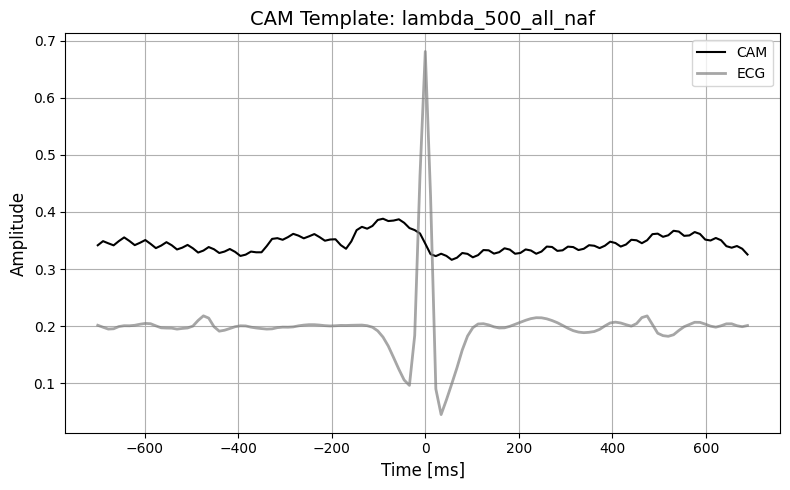

In [37]:
file_name = 'lambda_500_all_naf'
with open(f'ECG/saved_models/{file_name}/{file_name}_test_res.pkl', 'rb') as f:
    all_test_res = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_test_r2_rr_included_fixed.pkl', 'rb') as f:
    all_r2_rr = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_test_r2_p_wave_excluded_fixed.pkl', 'rb') as f:
    all_r2_pwave = pkl.load(f)
with open(f'ECG/saved_models/{file_name}/{file_name}_rep2label_perf.pkl', 'rb') as f:
    rep2label_perf = pkl.load(f)
    
rep2label_acc = np.mean([rep2label_perf[i]['accuracy'] for i in range(5)])
rep2label_F1_NAF = np.mean([rep2label_perf[i]['f1_normal'] for i in range(5)])
rep2label_F1_AF = np.mean([rep2label_perf[i]['f1_af'] for i in range(5)])
    
all_acc    = all_test_res['accuracy']
all_F1_NAF = all_test_res['f1_normal']
all_F1_AF  = all_test_res['f1_af']

print(f'Accuracy: {all_acc:.2f}')
print(f'F1 AF: {all_F1_AF:.3f}')
print(f'F1 NAF: {all_F1_NAF:.3f}')
print(f'R2 rr: {all_r2_rr:.3f}')
print(f'R2 pwave: {all_r2_pwave:.3f}')
print("")
print(f'Rep2Label Accuracy: {rep2label_acc:.2f}')
print(f'Rep2Label F1 AF: {rep2label_F1_AF:.2f}')
print(f'Rep2Label F1 NAF: {rep2label_F1_NAF:.2f}')
print("")

plot_noisy = False
fig = plot_cam_template(file_name=file_name,plot_noisy=plot_noisy)
suffix = '_noise' if plot_noisy else ''
fig.savefig(f'Figures/All{suffix}.png', dpi=500)